# Single-cell Time Series Interpolation

This notebook runs OT-CFM, SB-CFM and SF2M on the embryoid body data, preprocessed according to the notebooks in `preprocessing`. Here we optimize a single network to model cells over time on the 2D PHATE projection. The same process applies for any other representation. In the paper we compare quantitatively on PCA components and highly variable genes.

Note that to run this notebook you well need the `ebdata_v3.h5ad` data object, which is accessible at ___________________

Note that to reproduce the results in the paper, the PC dimensions are taken from this data object https://github.com/KrishnaswamyLab/TrajectoryNet/blob/master/data/eb_velocity_v5.npz, which is not quite the same as the PCs here due to different preprocessing. The highly variable genes were selected with the `sc.pp.highly_variable_genes` function with `n_top_genes=XXX`.

To train the model here we build a batch of all timepoint pairs together. This seems to be the most stable if large batches are affordable.

In [1]:
%load_ext autoreload
%autoreload 2
import os
import torch
from tqdm import tqdm

import torchsde
from torchdyn.core import NeuralODE
import matplotlib.pyplot as plt
import scanpy as sc
import numpy as np

from torchcfm.conditional_flow_matching import *
from torchcfm.utils import torch_wrapper, SDE, plot_trajectories
from torchcfm.models import MLP

savedir = "models/single-cell"
os.makedirs(savedir, exist_ok=True)

/home/mila/a/alexander.tong/.conda/envs/trajectory-inference/lib/python3.10/site-packages/lightning_utilities/core/imports.py:93: UserWarning: Unbuilt egg for MIOFlow [unknown version] (/home/mila/a/alexander.tong/MIOFlow)
  pkg_resources.require(self.requirement)


In [2]:
adata = sc.read_h5ad("../data/time_series/ebdata_v3.h5ad")
adata

AnnData object with n_obs × n_vars = 18203 × 17789
    obs: 'sample_labels', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'leiden', 'dpt_pseudotime', '1d-phate', '1d-phate-normalized'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'gene_name', 'gene_id', 'gene_name_id'
    uns: 'diffmap_evals', 'iroot', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'sample_labels_colors', 'tsne', 'umap'
    obsm: 'X_diffmap', 'X_pca', 'X_phate', 'X_phate_normalized', 'X_phate_real_time', 'X_phate_time', 'X_tsne', 'X_umap'
    obsp: 'connectivities', 'distances'

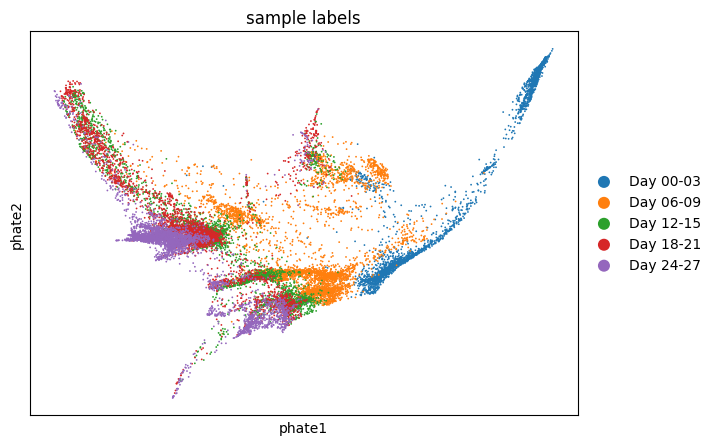

In [3]:
sc.pl.scatter(adata, basis="phate", color="sample_labels")

In [4]:
n_times = len(adata.obs["sample_labels"].unique())
# Standardize coordinates
coords = adata.obsm["X_phate"]
coords = (coords - coords.mean(axis=0)) / coords.std(axis=0)
adata.obsm["X_phate_standardized"] = coords
X = [adata.obsm["X_phate_standardized"][adata.obs["sample_labels"].cat.codes == t] for t in range(n_times)]

In [5]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
batch_size = 256
sigma = 0.1
dim = 2
model = MLP(dim=dim, time_varying=True, w=64)
#score_model = MLP(dim=dim, time_varying=True, w=64)
optimizer = torch.optim.Adam(model.parameters(), 1e-4)
#FM = ConditionalFlowMatcher(sigma=sigma)
FM = ExactOptimalTransportConditionalFlowMatcher(sigma=sigma)


In [6]:
import scprep
def plot_trajectories(traj, legend=True):
    n = 2000
    fig, ax = plt.subplots(1,1, figsize=(10, 10))
    scprep.plot.scatter(adata.obsm["X_phate_standardized"][:,0], adata.obsm["X_phate_standardized"][:,1], c=adata.obs["sample_labels"], ax=ax)
    #ax.scatter(traj[0, :n, 0], traj[0, :n, 1], s=10, alpha=0.8, c="black")
    ax.scatter(traj[:, :n, 0], traj[:, :n, 1], s=0.4, alpha=0.1, c="olive")
    #ax.scatter(traj[-1, :n, 0], traj[-1, :n, 1], s=4, alpha=1, c="blue")

    for i in range(5, 15):
        ax.plot(traj[:, i, 0], traj[:, i, 1], alpha=0.9, c="red")
    if legend:
        plt.legend([r"$p_0$", r"$p_t$", r"$p_1$", r"$X_t \mid X_0$"])
    #plt.xticks([])
    #plt.yticks([])
    #plt.axis("off")

def get_batch(FM, X, batch_size, n_times, return_noise=False):
    """ Construct a batch with point sfrom each timepoint pair
    """
    ts = []
    xts = []
    uts = []
    noises = []
    for t_start in range(n_times - 1):
        x0 = torch.from_numpy(X[t_start][np.random.randint(X[t_start].shape[0], size=batch_size)]).float().to(device)
        x1 = torch.from_numpy(X[t_start+1][np.random.randint(X[t_start+1].shape[0], size=batch_size)]).float().to(device)
        if return_noise:
            t, xt, ut, eps = FM.sample_location_and_conditional_flow(x0, x1, return_noise=return_noise)
            noises.append(eps)
        else:
            t, xt, ut = FM.sample_location_and_conditional_flow(x0, x1, return_noise=return_noise)
        ts.append(t + t_start)
        xts.append(xt)
        uts.append(ut)
    t = torch.cat(ts)
    xt = torch.cat(xts)
    ut = torch.cat(uts)
    if return_noise:
        noises = torch.cat(noises)
        return t, xt, ut, noises
    return t, xt, ut

## OT-CFM

In [7]:
for i in tqdm(range(10000)):
    optimizer.zero_grad()
    t, xt, ut = get_batch(FM, X, batch_size, n_times)
    vt = model(torch.cat([xt, t[:, None]], dim=-1))
    loss = torch.mean((vt - ut) ** 2)
    loss.backward()
    optimizer.step()

100%|████████████████████████████████████████████| 10000/10000 [15:42<00:00, 10.62it/s]


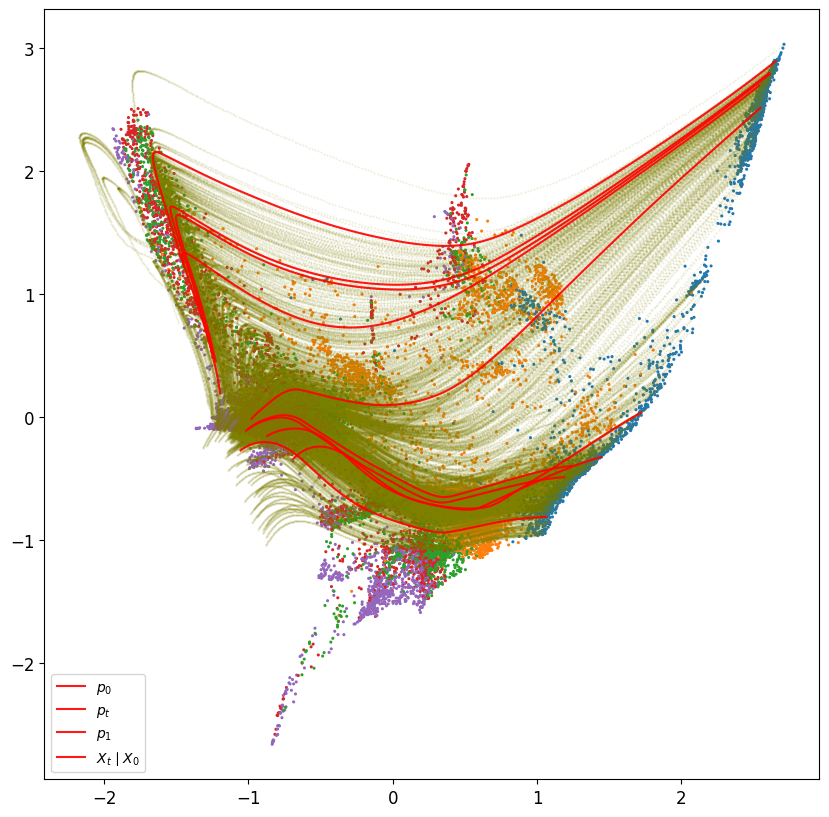

In [8]:
node = NeuralODE(
    torch_wrapper(model), solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4
)
with torch.no_grad():
    traj = node.trajectory(
        torch.from_numpy(X[0][:1000]).float(),
        t_span=torch.linspace(0, 4, 400),
    )
    plot_trajectories(traj)

## SF2M



In [37]:
sigma = 0.25
model = MLP(dim=dim, time_varying=True, w=64)
score_model = MLP(dim=dim, time_varying=True, w=64)
optimizer = torch.optim.AdamW(list(model.parameters()) + list(score_model.parameters()), 1e-4)
SF2M = SchrodingerBridgeConditionalFlowMatcher(sigma=sigma)

In [38]:
max_norm_ut = torch.tensor(0.0)
for i in tqdm(range(10000)):
    optimizer.zero_grad()
    t, xt, ut, eps = get_batch(SF2M, X, batch_size, n_times, return_noise=True)
    lambda_t = SF2M.compute_lambda(t % 1)
    vt = model(torch.cat([xt, t[:, None]], dim=-1))
    st = score_model(torch.cat([xt, t[:, None]], dim=-1))
    flow_loss = torch.mean((vt - ut) ** 2)
    max_norm_ut = torch.maximum(torch.max(torch.sum(ut ** 2, dim=1)), max_norm_ut)
    score_loss = torch.mean((lambda_t[:, None] * st + eps) ** 2)
    if i % 1000 == 0:
        print(max_norm_ut)
        print(f"{i}: {flow_loss.item():0.2f}, {score_loss.item():0.2f}")
    loss = flow_loss + score_loss
    
    loss.backward()
    optimizer.step()

  0%|               | 0/10000 [00:00<?, ?it/s]

tensor(116.4250)
0: 0.97, 1.78


 10%|▍   | 1005/10000 [01:01<05:13, 28.66it/s]

tensor(35265.3672)
1000: 0.35, 0.92


 20%|▊   | 2006/10000 [02:27<04:28, 29.72it/s]

tensor(75043.9844)
2000: 0.33, 0.88


 30%|█▏  | 3004/10000 [03:52<04:04, 28.62it/s]

tensor(383541.7500)
3000: 0.45, 0.83


 40%|█▌  | 4004/10000 [05:12<03:23, 29.47it/s]

tensor(383541.7500)
4000: 0.34, 0.78


 50%|██  | 5004/10000 [05:59<02:53, 28.79it/s]

tensor(383541.7500)
5000: 0.26, 0.80


 60%|██▍ | 6005/10000 [06:53<02:14, 29.81it/s]

tensor(383541.7500)
6000: 0.29, 0.78


 70%|██▊ | 7004/10000 [08:39<01:44, 28.73it/s]

tensor(383541.7500)
7000: 0.32, 0.79


 80%|███▏| 8006/10000 [10:14<01:07, 29.36it/s]

tensor(383541.7500)
8000: 0.73, 0.85


 90%|███▌| 9006/10000 [11:04<00:34, 28.67it/s]

tensor(383541.7500)
9000: 0.27, 0.77


100%|███| 10000/10000 [12:12<00:00, 13.65it/s]


In [39]:
node = NeuralODE(
    torch_wrapper(model), solver="euler", sensitivity="adjoint", atol=1e-4, rtol=1e-4
)
x0 = torch.from_numpy(X[0][:1000]).float()
with torch.no_grad():
    traj = node.trajectory(
        x0,
        t_span=torch.linspace(0, n_times - 1, 400).to(device),
    )


/home/mila/a/alexander.tong/.conda/envs/trajectory-inference/lib/python3.10/site-packages/torchdyn/numerics/odeint.py:84: UserWarning: Setting tolerances has no effect on fixed-step methods
  warn("Setting tolerances has no effect on fixed-step methods")


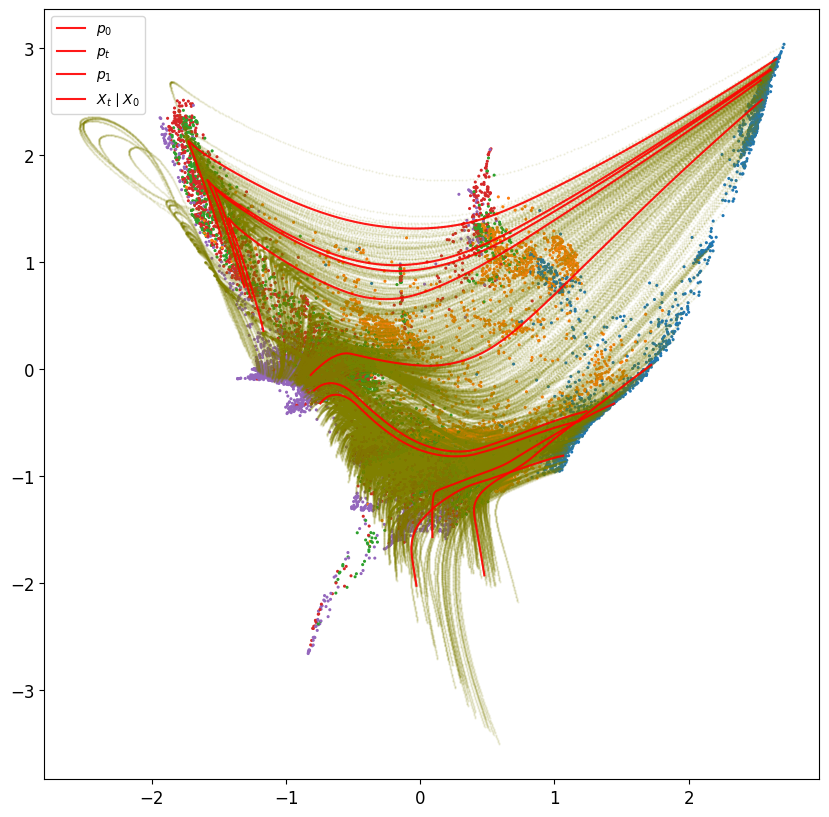

In [40]:
plot_trajectories(traj)

In [41]:

sde = SDE(model, score_model, noise=sigma)
with torch.no_grad():
    sde_traj = torchsde.sdeint(
        sde,
        x0,
        ts=torch.linspace(0, n_times - 1, 400),
    )

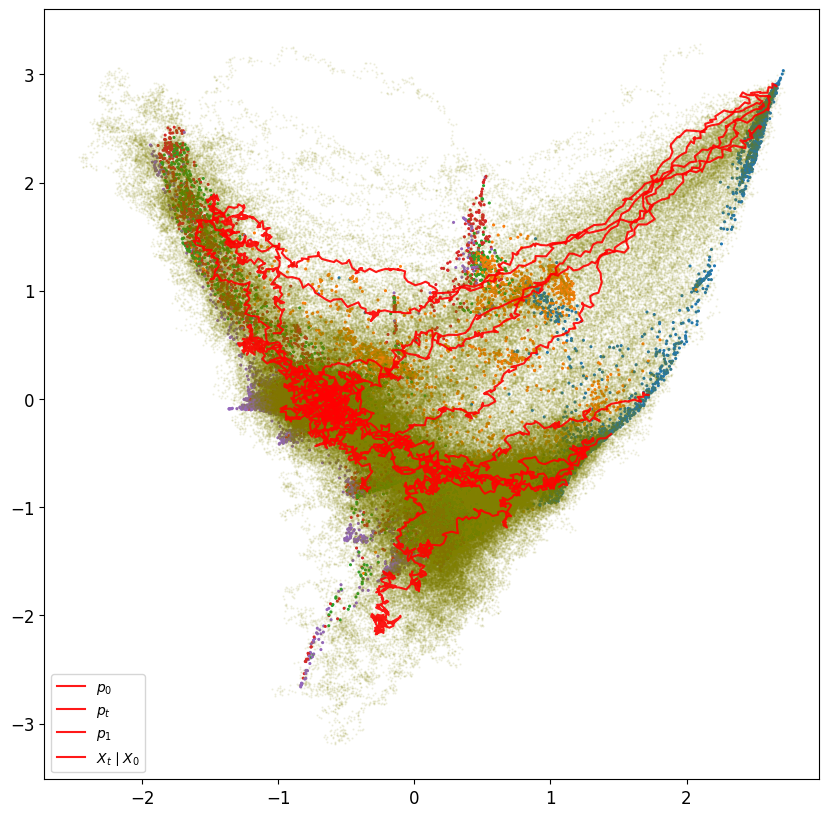

In [42]:
plot_trajectories(sde_traj)